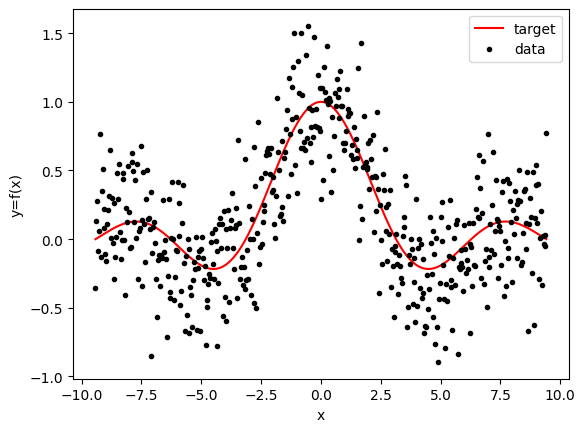

In [1]:

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada
y = np.sinc(X/np.pi) #función sinc -> objetivo
var = 0.1 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [2]:

ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida

(500, 1)
(500, 1)


0
(350, 1)
(150, 1)


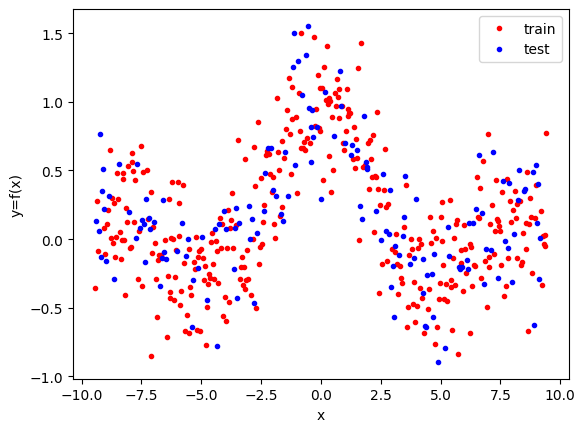

In [3]:

from sklearn.model_selection import train_test_split, GridSearchCV,cross_val_score, cross_val_predict,ShuffleSplit

#particionar datos
rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


X_train, X_test, y_train, y_test = Xdata[train_i], Xdata[test_i], ydata[train_i], ydata[test_i]

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

In [5]:

import matplotlib.pyplot as plt
import numpy as np


def plot_gpr_samples(gpr_model, X, x, n_samples, ax,xlabel_="x",ylabel_="y"):
    """Plot samples drawn from the Gaussian process model.

    If the Gaussian process model is not trained then the drawn samples are
    drawn from the prior distribution. Otherwise, the samples are drawn from
    the posterior distribution. Be aware that a sample here corresponds to a
    function.

    Parameters
    ----------
    gpr_model : `GaussianProcessRegressor`
        A :class:`~sklearn.gaussian_process.GaussianProcessRegressor` model.
    X: input samples in N x P
    n_samples : int
        The number of samples to draw from the Gaussian process distribution.
    ax : matplotlib axis
        The matplotlib axis where to plot the samples.
    """


    y_mean, y_std = gpr_model.predict(X, return_std=True) #predicted output from gpr
    y_samples = gpr_model.sample_y(X, n_samples)


    for idx, single_prior in enumerate(y_samples.T):
        ax.plot(
            x,
            single_prior,
            linestyle="--",
            alpha=0.7,
            label=f"Sampled function #{idx + 1}",
        )
    ax.plot(x, y_mean, color="black", lw=2)
    ax.fill_between(
        x,
        y_mean - 2*y_std,
        y_mean + 2*y_std,
        alpha=0.2,
        color="black",
        label=r" 2 std. dev.",
    )
    ax.set_xlabel(xlabel_)
    ax.set_ylabel(ylabel_)
    #ax.set_ylim([-3, 3])

## Cambio del kernel

$$k(x_i , x_j )= e^{-\frac{d(x_i,x_j)^2}{2l^2} } $$

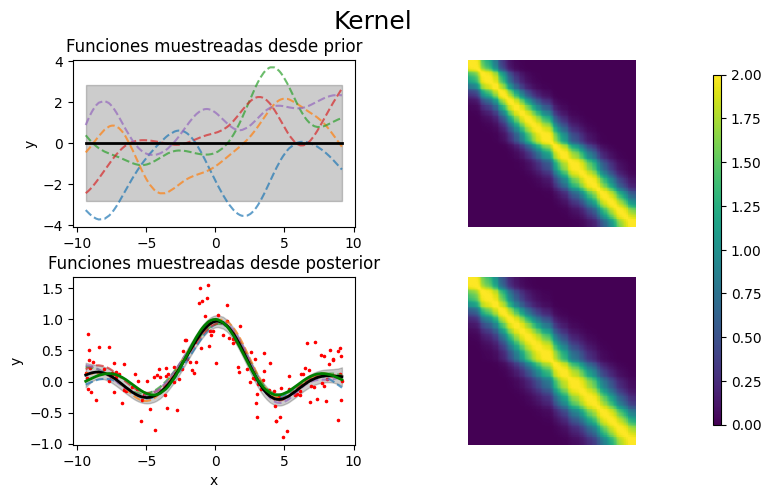

Kernel hiperparametros antes de entrenar:
1.41**2 * RBF(length_scale=2))


Kernel hiperparametros después de entrenar: 
0.434**2 * RBF(length_scale=2.37) 
Log-likelihood: -96.247




In [13]:
#entrenar gpr
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, DotProduct,ExpSineSquared, ConstantKernel, WhiteKernel
import matplotlib


#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.1#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(2.0, (1e-1, 1e3)) * RBF(2.0, (1e-3, 1e3))# ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*RBF(length_scale=1,length_scale_bounds=(1e-1, 10.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*DotProduct(sigma_0=1.0, sigma_0_bounds=(1e-05, 100000.0))+ConstantKernel(constant_value=1.0, constant_value_bounds=(0.0, 10.0))*ExpSineSquared(length_scale=1.0, periodicity=1.0, length_scale_bounds=(1e-05, 100000.0), periodicity_bounds=(1e-05, 100000.0))
#crear gpr
gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenar:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)

In [9]:

np.exp(gpr.kernel_.theta)#hiperparametros optimizados por el GPR

array([0.18874644, 2.36652297])

## GPR para la señal propuesta

$$ t_n = A sin(2\pi F_1 x_n) + B cos(2\pi F_2 x_n)+ \eta _n$$

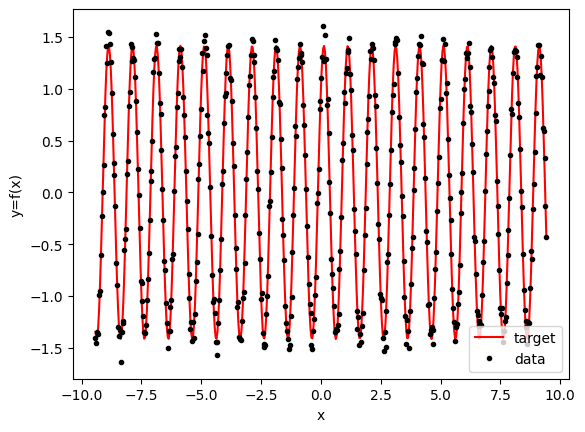

In [34]:
N = 500 #número de muestras
X = np.linspace(-3*np.pi,3*np.pi,N) #vector de entrada
F1 = 1
F2 = 1
y = np.sin(2*np.pi*F1*X)+ np.cos(2*np.pi*F2*X) #función sinc -> objetivo
var = 0.01 #varianza del ruido
mue = 0 #media del ruido
noise = mue + np.sqrt(var)*np.random.randn(X.shape[0])#ruido blanco
yn = y + noise #señal co ruido
plt.plot(X,y,'r',label='target' )
plt.plot(X,yn,'k.',label='data')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

(500, 1)
(500, 1)
0
(350, 1)
(150, 1)


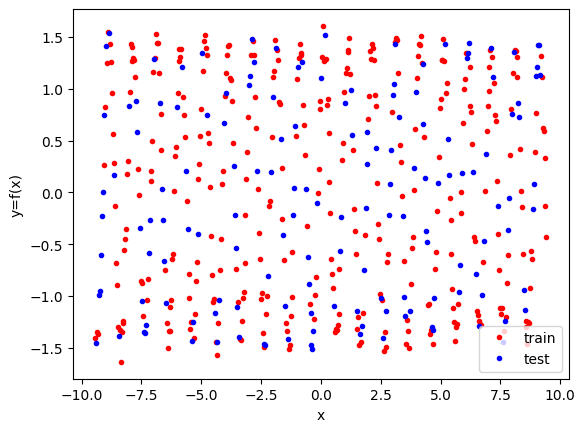

In [35]:

ydata = yn.reshape(-1,1)
Xdata = X.reshape(-1,1)
print(Xdata.shape) # N = 500 muestras, P = 1 atributos
print(ydata.shape) # N = 500, regresion univarida


rs = ShuffleSplit(n_splits=1, random_state=0, test_size=0.3)
for i, (train_i, test_i) in enumerate(rs.split(X)):
   print(i)


X_train, X_test, y_train, y_test = Xdata[train_i], Xdata[test_i], ydata[train_i], ydata[test_i]

print(X_train.shape)
print(X_test.shape)

plt.plot(X_train,y_train,'r.',label='train' )
plt.plot(X_test,y_test,'b.',label='test')
plt.legend()
plt.xlabel('x')
plt.ylabel('y=f(x)')
plt.show()

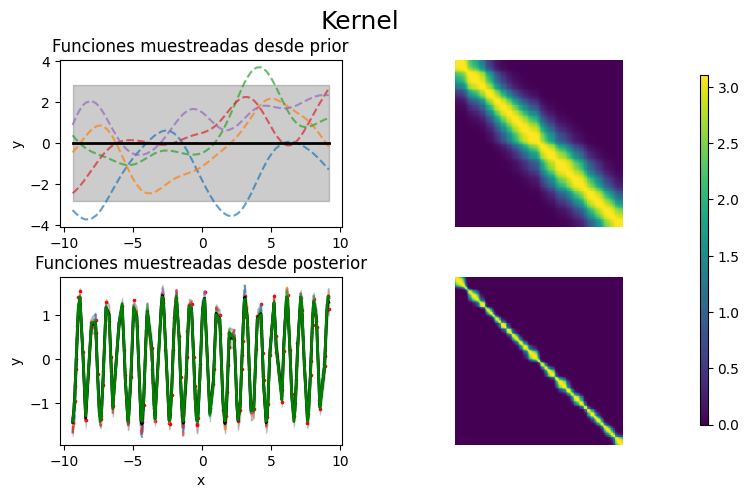

Kernel hiperparametros antes de entrenar:
1.41**2 * RBF(length_scale=2))


Kernel hiperparametros después de entrenar: 
1.76**2 * RBF(length_scale=0.334) 
Log-likelihood: -40.039




In [42]:

#organizar datos para graficar
ind_ = np.argsort(X_test,axis=0).reshape(-1)

#definir gpr
alpha = 0.06#*1/np.var(y_train)#1e-5
#kernel
kernel = ConstantKernel(2.0, (1e-1, 1e3)) * RBF(2.0, (1e-3, 1e3))

gpr = GaussianProcessRegressor(kernel=kernel, alpha=alpha, random_state=0)#crear objeto gpr

fig, axs = plt.subplots(nrows=2,  ncols=2, figsize=(8, 5))

# plot kernel prior
K_prior = kernel(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[0,1].imshow(K_prior)
axs[0,1].axis('off')

# plot prior
n_samples = 5
plot_gpr_samples(gpr, X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[0,0],xlabel_="")
axs[0,0].set_title("Funciones muestreadas desde prior")
#axs[0,0].set_ylim([-2,2])

# plot posterior
gpr.fit(X_train, y_train) #entrenar GPR en train

plot_gpr_samples(gpr,  X_test[ind_,0].reshape(-1,1), X_test[ind_,0].ravel(),
                 n_samples=n_samples, ax=axs[1,0])
axs[1,0].scatter(X_test[ind_, 0], y_test[ind_], color="red",marker='.',s=10)
axs[1,0].plot(X_test[ind_, 0], y[test_i][ind_], color="g",lw=2) #target ytest
axs[1,0].set_title("Funciones muestreadas desde posterior")

# plot kernel posterior después de entrenar
K_posterior = gpr.kernel_(X_test[ind_,0].reshape(-1,1),X_test[ind_,0].reshape(-1,1))
axs[1,1].imshow(K_posterior)
axs[1,1].axis('off')


cax = fig.add_axes([0.925, 0.15, 0.01, 0.7])
norm = matplotlib.colors.Normalize(vmin=min(np.append(K_prior.ravel(),K_posterior.ravel())),
                                   vmax=max(np.append(K_prior.ravel(),K_posterior.ravel())))
sm = plt.cm.ScalarMappable(cmap=None, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm,cax=cax)


fig.suptitle("Kernel", fontsize=18)
plt.subplots_adjust(hspace=0.3)
#plt.tight_layout()

plt.show()

print(f"Kernel hiperparametros antes de entrenar:\n{kernel})")
print(
    f"\n\nKernel hiperparametros después de entrenar: \n{gpr.kernel_} \n"
    f"Log-likelihood: {gpr.log_marginal_likelihood(gpr.kernel_.theta):.3f}\n\n"
)